In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from glob import glob
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Exploratory Data Analysis

<ipython-input-2-45e9e1dda700>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")


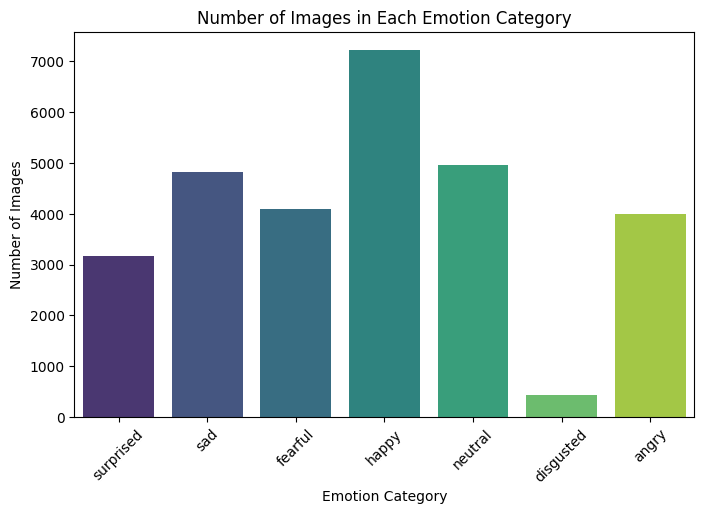

In [2]:
train_dir = '/content/dataset/train'

categories = os.listdir(train_dir)

image_counts = {category: len(os.listdir(os.path.join(train_dir, category))) for category in categories}

plt.figure(figsize=(8,5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.xlabel("Emotion Category")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Emotion Category")
plt.xticks(rotation=45)
plt.show()


It is observed that there is class imbalance in the dataset so we should take into account metrics such as precision and recall for each class.

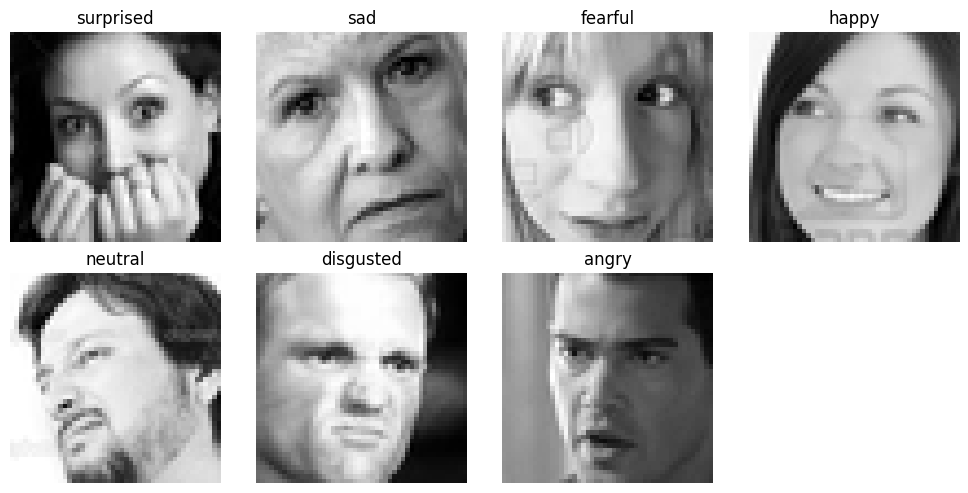

In [3]:
categories = os.listdir(train_dir)
plt.figure(figsize=(10,5))

for i, cat in enumerate(categories):
  cat_path = os.path.join(train_dir, cat)
  img_path = os.path.join(cat_path, os.listdir(cat_path)[0])
  image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  plt.subplot(2, 4, 1+i)
  plt.imshow(image, cmap='grey')
  plt.title(cat)
  plt.axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation

---

I am going to apply data augmantation to the training images in order to increase the generalizability of the model. I will use Keras' *ImageDataGenerator* class in order to implement data augmentation on-the-fly (it happenes during training) and the model sees new variations of the trained data at each and every epoch.

We consider the following steps when applying in-place data augmentation:
  * An input batch of images is presented to the ImageDataGenerator.
  * The ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
  * The randomly transformed batch is then returned to the calling function.


In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

In [5]:
img_size = 48
batch_size = 32

training_data = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training',
    shuffle = True,
    seed = 23
)

validation_data = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation',
    shuffle = True,
    seed = 11
)

test_data = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = False,
    seed = 10
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Plotting augmented training images alongside their labels


In [6]:
class_labels = list(training_data.class_indices.keys())
print(class_labels)


['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


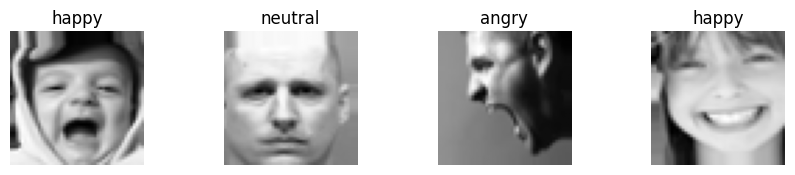

In [11]:
img, label = training_data.__next__()
plt.figure(figsize=(10,5))

random_indices = random.sample(range(img.shape[0]), 4)

for idx, i in enumerate(random_indices):  # Loop through unique indices
    image = img[i]
    labl = class_labels[label[i].argmax()]

    plt.subplot(1, 4, idx + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title(labl)
    plt.axis("off")


plt.subplots_adjust(wspace=0.6)
plt.show()

# Convolutional Neural Network

---

In this section I am going to build and train the CNN model for image classification.

In [29]:
def create_model(input_shape=(48,48,1), num_classes=7):
  model = Sequential()

  # Block 1
  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  # Fully Connected Layers (Head part)
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # Output Layer
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [30]:
cnn = create_model()
cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │         184,330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │              77 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,895 (722.25 KB)

 Trainable params: 184,811 (721.92 KB)

 Non-trainable params: 84 (336.00 B)

In [32]:
cnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

I am going to train the CNN model for 100 epochs. I will implement early stopping to stop the training if the validation loss does not decrease after 3 consecutive epochs.

In [33]:
epochs = 100
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn.fit(
    training_data,
    epochs = epochs,
    validation_data = validation_data,
    batch_size = 32,
    callbacks = [callback]
)

Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 108s 147ms/step - accuracy: 0.1792 - loss: 2.3292 - val_accuracy: 0.2357 - val_loss: 1.8987
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 96s 133ms/step - accuracy: 0.2166 - loss: 1.9977 - val_accuracy: 0.3026 - val_loss: 1.8229
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.2464 - loss: 1.9193 - val_accuracy: 0.3121 - val_loss: 1.7942
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s 129ms/step - accuracy: 0.2646 - loss: 1.8727 - val_accuracy: 0.3310 - val_loss: 1.7462
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 92s 129ms/step - accuracy: 0.2830 - loss: 1.8194 - val_accuracy: 0.3430 - val_loss: 1.7358
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 91s 127ms/step - accuracy: 0.2873 - loss: 1.7952 - val_accuracy: 0.3484 - val_loss: 1.7067
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.2891 - loss: 1.7723 - val_accuracy: 0.3292 - val_loss: 1.7045
Epoch 8/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 87s 121ms/step - accuracy: 0.3005

In [34]:
cnn.save("model.h5") # save model and its architecture

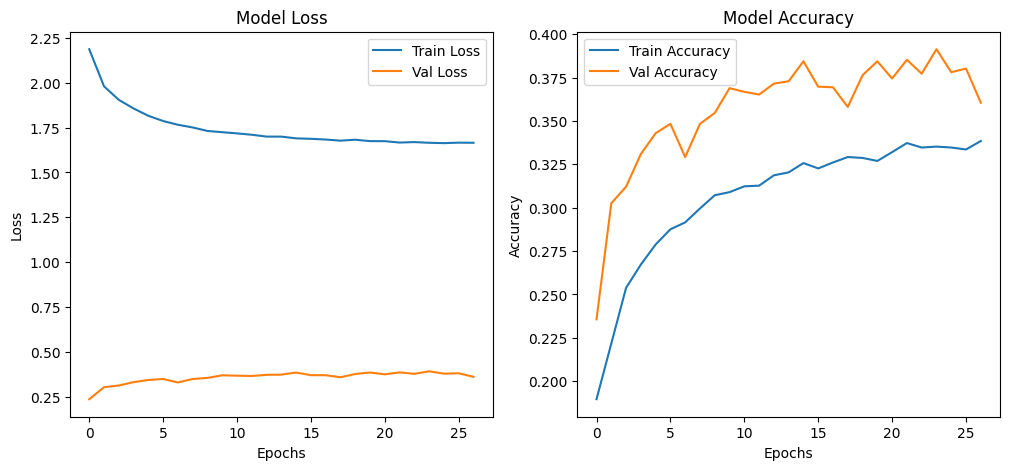

In [37]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_accuracy'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_metrics(history)


In [35]:
predictions = cnn.predict(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step


In [40]:
pred_classes = np.argmax(predictions, axis=1)

In [42]:
true_label = test_data.classes

In [45]:
acc = accuracy_score(true_label, pred_classes)
print("Accuracy of the CNN model: ", acc)
print('\n\n')
print(classification_report(true_label, pred_classes, target_names=list(training_data.class_indices.keys())))

Accuracy of the CNN model:  0.42156589579269993



              precision    recall  f1-score   support

       angry       0.42      0.07      0.11       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.25      0.13      0.17      1024
       happy       0.55      0.76      0.64      1774
     neutral       0.35      0.43      0.39      1233
         sad       0.34      0.27      0.30      1247
   surprised       0.40      0.72      0.52       831

    accuracy                           0.42      7178
   macro avg       0.33      0.34      0.30      7178
weighted avg       0.39      0.42      0.38      7178



**It is observed that the model fails to predict the *disgusted* emotion - which is and the class with fewer examples in the dataset. The model performs best in terms of both precision and recall for the *happy* emotion - which is the class with the most examples in the dataset.**

In [46]:
loaded_model= load_model("model.h5")

In [50]:
pred = loaded_model.predict(test_data)
pred_labels = np.argmax(pred, axis=1)

print(accuracy_score(true_label, pred_labels))
print('\n\n')
print(classification_report(true_label, pred_labels, target_names=list(training_data.class_indices.keys())))

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step
0.42156589579269993



              precision    recall  f1-score   support

       angry       0.42      0.07      0.11       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.25      0.13      0.17      1024
       happy       0.55      0.76      0.64      1774
     neutral       0.35      0.43      0.39      1233
         sad       0.34      0.27      0.30      1247
   surprised       0.40      0.72      0.52       831

    accuracy                           0.42      7178
   macro avg       0.33      0.34      0.30      7178
weighted avg       0.39      0.42      0.38      7178



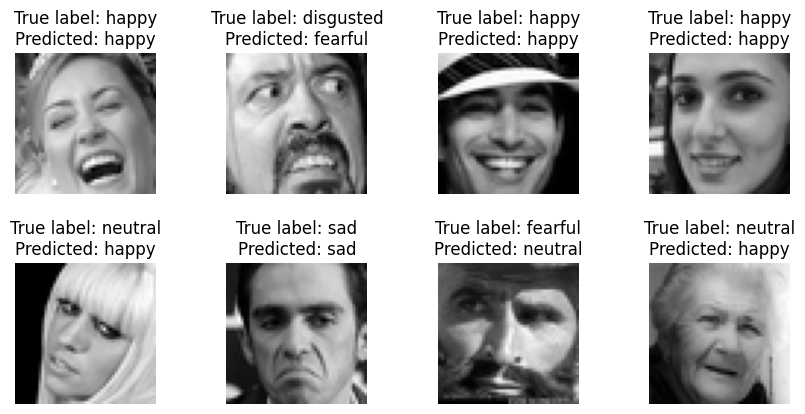

In [56]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (10,5))
axes =axes.flatten()

for i in range(8):
    j = np.random.randint(test_data.n)

    # take data
    batch_images, batch_labels = test_data[j // batch_size]
    id_in_batch = j % batch_size
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(f"True label: {class_labels[label]}\nPredicted: {class_labels[pred_classes[j]]}")
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)
plt.show()